In [12]:
import pandas as pd 
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
import numpy as np

df = pd.read_csv("data/us_change.csv", index_col=0)

## Análises

Objetivo: Modelar Consumption a partir das outras covariáveis

Nessa sessão, iremos fazer algumas análises exploratórias e lidaremos com algumas estatísticas para compreendermos melhor os nossos dados.

In [9]:
df

,Quarter,Consumption,Income,Production,Savings,Unemployment
1,1970 Q1,0.618566,1.044801,-2.452486,5.299014,0.9
2,1970 Q2,0.451984,1.225647,-0.551459,7.789894,0.5
3,1970 Q3,0.872872,1.585154,-0.358652,7.403984,0.5
4,1970 Q4,-0.271848,-0.239545,-2.185691,1.169898,0.7
5,1971 Q1,1.901345,1.975925,1.909764,3.535667,-0.1
...,...,...,...,...,...,...
194,2018 Q2,0.983112,0.661825,1.117424,-2.723974,0.0
195,2018 Q3,0.853181,0.806271,1.256722,-0.085686,-0.3
196,2018 Q4,0.356512,0.695142,0.948148,5.031337,0.2
197,2019 Q1,0.282885,1.100753,-0.488206,9.760287,-0.1


### Análise das variáveis ao longo do tempo

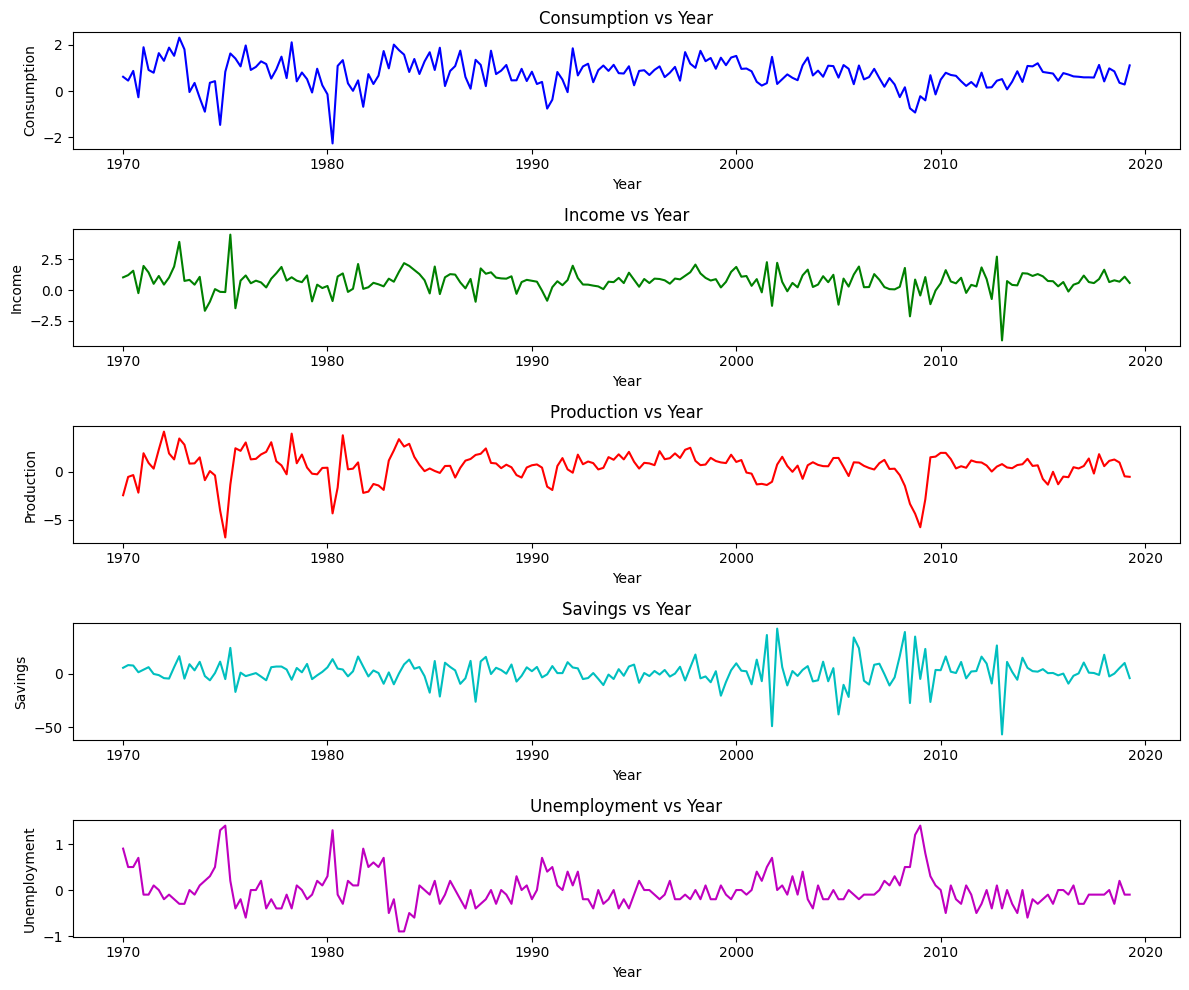

In [24]:
def convert_to_period(quarter):
    """
    Function to convert a string to a pandas period object. 
    Checks if the input is a string in the form '2019 Q1' or already a Period.
    """
    if isinstance(quarter, pd.Period):
        return quarter
    year, quarter_str = quarter.split()
    year = int(year)
    quarter = int(quarter_str[-1])
    return pd.Period(year=year, quarter=quarter, freq='Q')

df['Quarter'] = df['Quarter'].apply(convert_to_period)
df['Year'] = df['Quarter'].dt.to_timestamp()  # Converter para timestamps para plotagem

# Convert DataFrame columns to numpy arrays
years = np.array(df['Year'])
consumption = np.array(df['Consumption'])
income = np.array(df['Income'])
production = np.array(df['Production'])
savings = np.array(df['Savings'])
unemployment = np.array(df['Unemployment'])

plt.figure(figsize=(12, 10))


variables = {
    'Consumption': consumption,
    'Income': income,
    'Production': production,
    'Savings': savings,
    'Unemployment': unemployment
}

colors = ['b', 'g', 'r', 'c', 'm']  # Lista de cores

for i, (label, data) in enumerate(variables.items(), 1):
    plt.subplot(len(variables), 1, i)
    plt.plot(years, data, label=label, color=colors[i-1])
    plt.title(f'{label} vs Year')
    plt.xlabel('Year')
    plt.ylabel(label)
    plt.tight_layout()

plt.show()

Savings possui uma amplitude mais alta, com valores que variam de aproximadamente $-57$ e $41$. Isso sugere que alguma transformação logaritmica para adequar as escalas possa ser interessante em alguns modelos.
Além disso, utilizar uma normalização Z-Score para Comsumption, Income, Production e Unemployment pode agregar dependendo de qual modelo testaremos, principalmente nos mais sensíveis a escalas.

### Teste de Dickey-Fuller

In [ ]:
adf_result = adfuller(df['Consumption'])

print("Estatística do Teste ADF:", adf_result[0])
print("Valor-p:", adf_result[1])
print("Valores Críticos:")
for key, value in adf_result[4].items():
    print(f'  {key}: {value}')

Estatística do Teste ADF: -4.610123144902199
Valor-p: 0.00012373240927130775
Valores Críticos:
  1%: -3.464337030867007
  5%: -2.876478799035722
  10%: -2.574733103221565


Utilizamos Dickey-Fuller para compreendermos se nossa série é ou não estacionária. Como nossa estatística de teste foi menor do que todos os valores críticos, rejeitamos a hipótese nula de não estacionariedade. 

### Função de Autocorrelação (ACF)

Agora, vamos analisar o gráfico de ACF das observações:

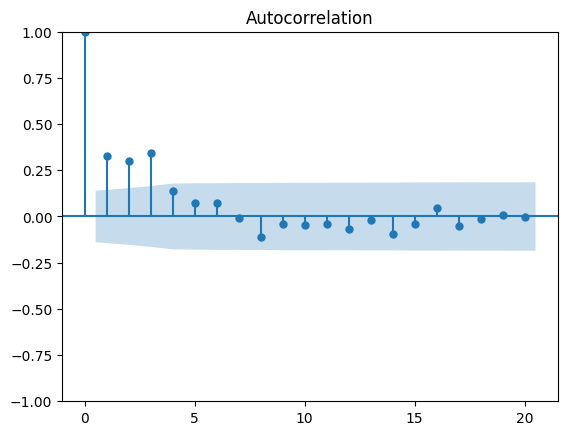

In [22]:
plot_acf(df['Consumption'], lags=20)
plt.show()

A série parece ter uma alta relação em efeitos de curto prazo (lags 1, 2 e 3). Vamos explorar melhor isso futuramente.

### Métricas e métodos de avaliação

Utilizaremos o Erro Absoluto Médio (MAE) para avaliação, pela facilidade de interpretação. Também utilizaremos Raiz do Erro Quadrático Médio (RMSE) para conferirmos se há valores que distoam muito das previsões; O valor real $y_t$ se aproxima de $0$, portanto MAPE não é uma escolha ideal. Por isso, utilizaremos MASE para erros percentuais.


In [ ]:
df.describe()

,Consumption,Income,Production,Savings,Unemployment
count,198.000000,198.000000,198.000000,198.000000,198.000000
mean,0.742482,0.728169,0.507083,1.392258,0.001010
std,0.637863,0.900393,1.521350,11.966324,0.367318
min,-2.277836,-4.084420,-6.836039,-56.471910,-0.900000
25%,0.417479,0.314376,-0.010780,-4.049088,-0.200000
50%,0.776656,0.760346,0.666085,1.349359,-0.100000
75%,1.097577,1.160228,1.295245,6.341144,0.100000
max,2.319558,4.521869,4.154295,41.607730,1.400000


### Necessidade de decomposição entre tendência e sazonalidade

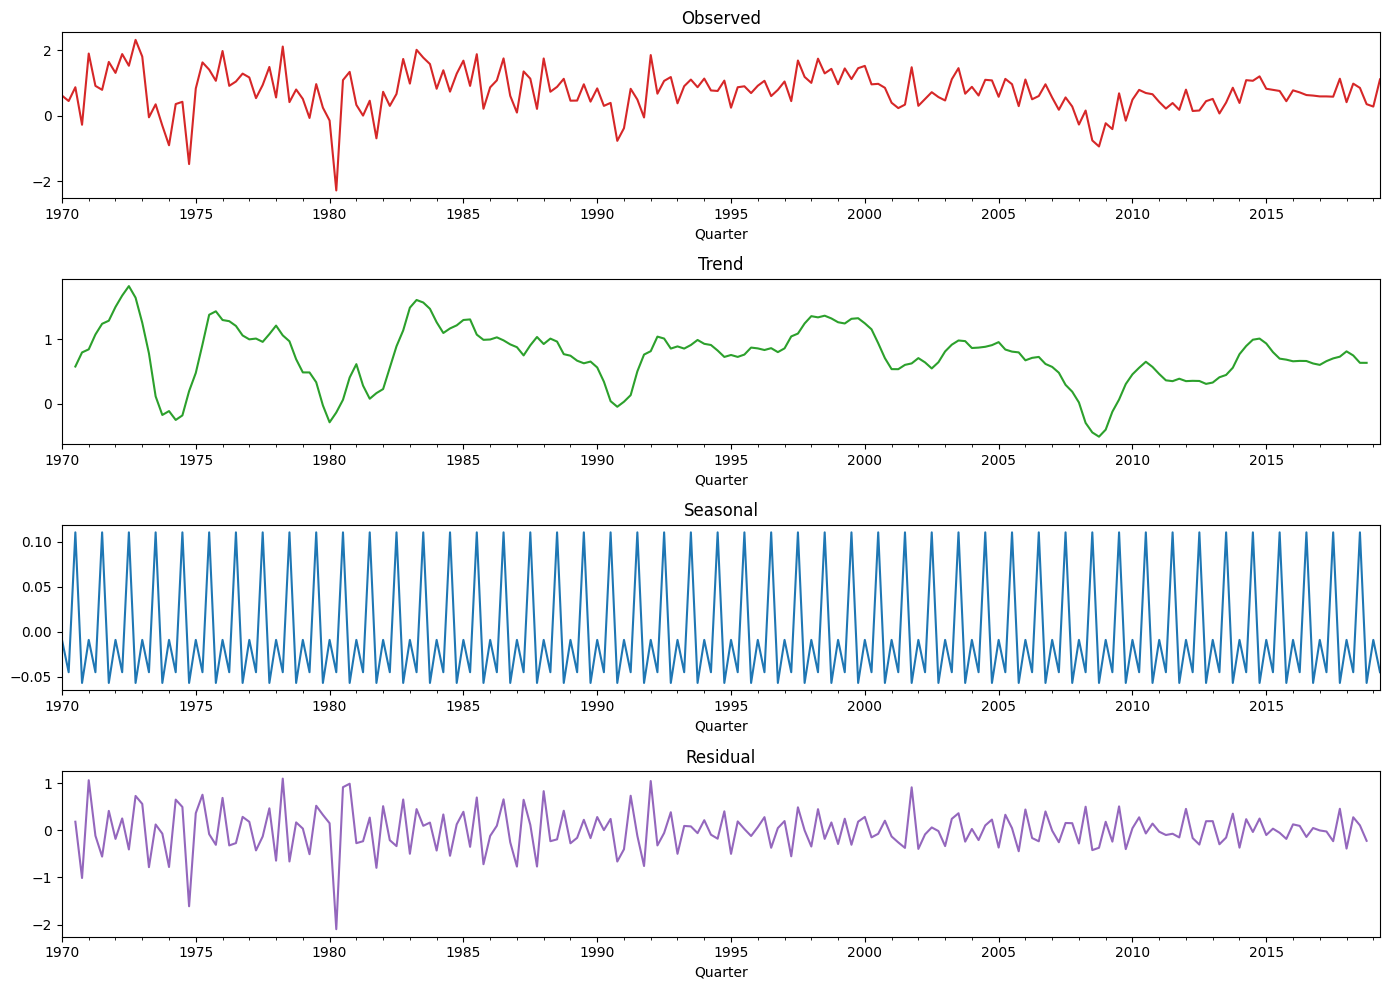

In [26]:
df = df.set_index('Quarter')
series = df['Consumption']

result = seasonal_decompose(series, model='additive', period=4)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 10))
result.observed.plot(ax=ax1, color='tab:red', title='Observed')
result.trend.plot(ax=ax2, color='tab:green', title='Trend')
result.seasonal.plot(ax=ax3, color='tab:blue', title='Seasonal')
result.resid.plot(ax=ax4, color='tab:purple', title='Residual')

plt.tight_layout()
plt.show()

A série temporal parece ter uma sazonalidade bem definida, constante ao longo do tempo. A tendência é variável. Os resíduos possuem alguns picos ao longo dos anos mas parece se comportar normalmente em torno de 0.